In [1]:
## Building Chatbot with multiple tools using a langgraph

## Create a chatbot with tool capabilities using arxiv, wikipedia search and some functions
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)
print(wikipedia.name)

wikipedia


In [6]:
wikipedia.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

/var/folders/w0/jqmsjv3s0fdf4vt1c98f61x00000gn/T/ipykernel_38366/1535493036.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for August 12, 2025")

[{'title': 'Artificial Intelligence News Highlights, 12 August 2025',
  'url': 'https://www.moneycontrol.com/world/artificial-intelligence-news-live-updates-12-08-2025-alpha-liveblog-13440041.html',
  'content': 'A company in Malaysia has created a new AI large language model specifically designed to serve the global Muslim population, which is estimated at around 2 billion people, according to a report in Bloomberg. The project leverages foundational open-source AI technology from the Chinese AI firm DeepSeek. This development is part of a wider trend in which AI systems are being localized to meet the unique cultural, linguistic, and religious needs of specific communities, addressing concerns about [...] address reports that its AI-driven search features are negatively impacting web traffic to publisher sites. Google has stated that click volume has remained “relatively stable” and that users are increasingly navigating to websites with diverse content like forums and videos. [...] 

In [9]:
### Combine all the tools in the list

tools = [arxiv, wikipedia, tavily]

In [10]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

llm_tools = llm.bind_tools(tools)

In [11]:
from langchain_core.messages import AIMessage, HumanMessage
result = llm_tools.invoke([HumanMessage(content=f"What is the recent AI news?")])
result

AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about recent AI news. I need to figure out which tool to use here. Let me check the available functions. There's arxiv, wikipedia, and tavily_search.\n\nArxiv is for scientific papers, which might be too technical and not the best for general news. Wikipedia is good for general knowledge but might not have the most up-to-date information. Tavily_search is described as a search engine for current events, so that seems like the right choice here. The user wants recent news, so using tavily_search_results_json with a query about AI news makes sense. I'll go with that.\n", 'tool_calls': [{'id': '02c446x8m', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 159, 'prompt_tokens': 400, 'total_tokens': 559, 'completion_time': 0.464901834, 'prompt_time': 0.139857274, 'queue_time': 0.198

In [12]:
result.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '02c446x8m',
  'type': 'tool_call'}]

In [13]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

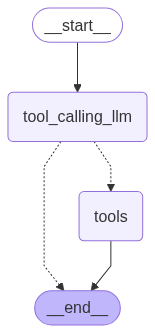

In [14]:
### Entire Chatbot with Langgraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

### Node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                            # If the latest message (result) from assistant is NOT a tool call -> tools_condition routes to END
                              tools_condition)

builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from pprint import pprint
messages = graph.invoke({"messages": HumanMessage(content="What is attention is all you need?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need?
================================== Ai Message ==================================
Tool Calls:
  arxiv (w83dneery)
 Call ID: w83dneery
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time o


In [16]:
from pprint import pprint
messages = graph.invoke({"messages": HumanMessage(content="What is machine learning")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (rjmdt5x95)
 Call ID: rjmdt5x95
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
